In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os

In [2]:
"""
Implementation of the noiseless VQE algorithm to find the ground state of lithium hydride (LiH) using double excitations only.

Different bond lengths are scanned to find the optimal value.
"""

'\nImplementation of the noiseless VQE algorithm to find the ground state of lithium hydride (LiH) using double excitations only.\n\nDifferent bond lengths are scanned to find the optimal value.\n'

In [ ]:
bond_lengths = np.linspace(1.1, 2.0, 10)
energies = []

# Define the atoms in the LiH molecule
symbols = ["Li", "H"]

In [4]:
for r in bond_lengths:
    coordinates = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, r]])
    
    # Step 1: Build Hamiltonian
    hamiltonian, qubits = qchem.molecular_hamiltonian(["Li", "H"], coordinates)

    # Step 2: HF State
    electrons = 4
    hf = qchem.hf_state(electrons=electrons, orbitals=qubits)
    
    # Step 3: Excitations
    _, doubles = excitations(electrons=electrons, orbitals=qubits)

    # Step 4: Device
    dev = qml.device("default.qubit", wires=qubits)

    # Step 5: Define ansatz, cost, etc. (same as before, now inside loop)
    @qml.qnode(dev)
    def cost_function(params):
        qml.BasisState(hf, wires=range(qubits))
        for i, excitation in enumerate(doubles):
            qml.DoubleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian)

    # Step 6: Optimize
    opt = qml.GradientDescentOptimizer(stepsize=0.8)
    theta = np.zeros(len(doubles), requires_grad=True)

    for _ in range(20):
        theta, _ = opt.step_and_cost(cost_function, theta)

    # Step 7: Record final energy
    final_energy = cost_function(theta)
    energies.append(final_energy)
    print(f"r = {r:.2f} Å → E = {final_energy:.8f} Ha")


r = 1.10 Å → E = -5.12656932 Ha
r = 1.20 Å → E = -5.33358613 Ha
r = 1.30 Å → E = -5.46682508 Ha
r = 1.40 Å → E = -5.54467190 Ha
r = 1.50 Å → E = -5.58263701 Ha
r = 1.60 Å → E = -5.59357194 Ha
r = 1.70 Å → E = -5.58794502 Ha
r = 1.80 Å → E = -5.57406087 Ha
r = 1.90 Å → E = -5.55822979 Ha
r = 2.00 Å → E = -5.54494958 Ha


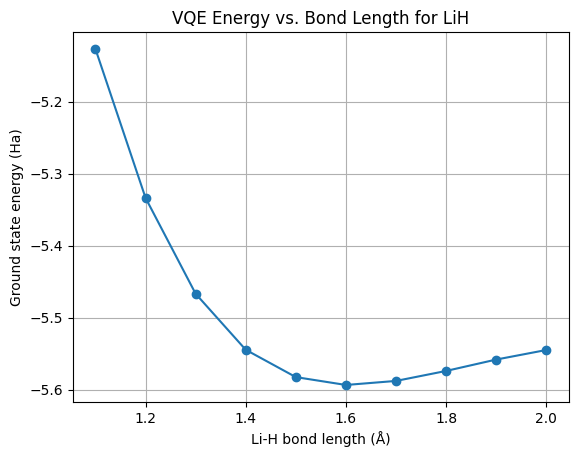

In [5]:
plt.plot(bond_lengths, energies, marker='o')
plt.xlabel("Li-H bond length (Å)")
plt.ylabel("Ground state energy (Ha)")
plt.title("VQE Energy vs. Bond Length for LiH")
plt.grid(True)
plt.savefig("images/LiH_Optimal_Bond_Length.png")
plt.show()

In [6]:
# Convert energies list to a NumPy array (for easy argmin)
energies = np.array(energies)

# Find index of the minimum energy
min_index = np.argmin(energies)

# Retrieve optimal bond length and energy
optimal_r = bond_lengths[min_index]
optimal_energy = energies[min_index]

# Print result
print(f"\nOptimal bond length: {optimal_r:.2f} Å")
print(f"Minimum ground state energy: {optimal_energy:.8f} Ha")


Optimal bond length: 1.60 Å
Minimum ground state energy: -5.59357194 Ha
